In [1]:
#IMPORTS
import pm4py
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, f1_score, confusion_matrix
from pm4py.algo.transformation.log_to_features import algorithm as log_to_features
from itertools import product

# Prepare the Data
The code below is used to generate the CVS file. You can also skip running it and instead load the CSV directly a few cells below.

First, make sure the permit log is in the current directory, then run the code below

In [2]:
travel_permits = pm4py.read_xes('PermitLog.xes.gz')

parsing log, completed traces ::   0%|          | 0/7065 [00:00<?, ?it/s]

First, we make sure we have the prefixes we need, we just want the events leading up to 'Start trip'

In [3]:
travel_prefixes = pm4py.filtering.filter_prefixes(travel_permits, 'Start trip')

In [4]:
#quick check to see if we got what we wanted
i = 39
for e in travel_permits[i]:
    print(e['concept:name'])
print() 
for e in travel_prefixes[i]:
    print(e['concept:name'])

Permit SUBMITTED by EMPLOYEE
Permit FINAL_APPROVED by SUPERVISOR
Start trip
End trip
Declaration SUBMITTED by EMPLOYEE
Declaration FINAL_APPROVED by SUPERVISOR
Request Payment
Payment Handled

Permit SUBMITTED by EMPLOYEE
Permit FINAL_APPROVED by SUPERVISOR


Check if a declaration was submitted before the trip started

In [5]:
decl_bools = np.zeros((7065,1))

for i,t in enumerate(travel_prefixes):
    for e in t:
        if e['concept:name'] == "Declaration SUBMITTED by EMPLOYEE":
            decl_bools[i,0] = 1
            
decl_bools.shape

(7065, 1)

Now extract the features we are interested in from the prefixes:

In [6]:
data_regr, _ = log_to_features.apply(travel_prefixes, parameters={'num_tr_attr': ["RequestedBudget","OverspentAmount"]})
data_class, _ = log_to_features.apply(travel_prefixes, parameters={'num_tr_attr': ["RequestedBudget","Overspent"]})

data_regre = np.array(data_regr).round(2)
data_class = np.array(data_class).round(2)
data_class.shape

(7065, 2)

However, we still need trip duration, which we will need to compute manually. We will use number of days to denote the duration

In [7]:
trip_durations = []
for trace in travel_permits:
    for e in trace:
        if e['concept:name'] == "Start trip": #note the time the trip started
            start_time = e['time:timestamp']
        elif e['concept:name'] == "End trip": #note the time the trip ended
            end_time = e['time:timestamp']
            break
    trip_durations.append((end_time-start_time).days) #save the trip duration in days
    
trip_durations = np.array(trip_durations).reshape((-1,1))
trip_durations.shape

(7065, 1)

And we do the same in order to get the duration between the permit being submitted and the permit being approved

In [8]:
perm_durations = []
for trace in travel_permits:
    started = False
    for e in trace:
        if e['concept:name'].startswith("Permit") and not started: #start time is the first time permit is mentioned
            started = True
            start_time = e['time:timestamp']
            end_time = e['time:timestamp']
        elif e['concept:name'].startswith("Permit"): #end time is the last time permit is mentioned
            end_time = e['time:timestamp']
    perm_durations.append((end_time-start_time).days) #save duration of permit handling in days
    
perm_durations = np.array(perm_durations).reshape((-1,1))
perm_durations.shape

(7065, 1)

Now we merge all the features we extracted into one dataframe

In [9]:
final_data_regr = np.concatenate((decl_bools, trip_durations, perm_durations, data_regr), axis=1)
final_data_regr_abs = np.absolute(np.concatenate((decl_bools, trip_durations, perm_durations, data_regr), axis=1))
final_data_class = np.concatenate((decl_bools, trip_durations, perm_durations, data_class), axis=1)
final_data_class.shape

(7065, 5)

Some exploration of the data we have now:

In [10]:
pd.DataFrame(data=final_data_class[:10,:])

,0,1,2,3,4
0,0.0,0.0,0.0,41.61,0.0
1,0.0,31.0,0.0,795.54,0.0
2,0.0,0.0,0.0,51.79,1.0
3,0.0,21.0,0.0,0.00,0.0
4,0.0,364.0,0.0,6020.79,0.0
5,0.0,2.0,0.0,245.06,0.0
6,0.0,6.0,0.0,0.00,0.0
7,0.0,3.0,0.0,1015.98,0.0
8,0.0,5.0,0.0,0.00,0.0
9,0.0,5.0,0.0,156.96,0.0


We can now save the data to CSV:

In [11]:
np.savetxt('ML_data_class.csv', final_data_class, delimiter=',')
np.savetxt('ML_data_regr.csv', final_data_regr, delimiter=',')
np.savetxt('ML_data_regr_abs.csv', final_data_regr_abs, delimiter=',')

# Load the CSV
Or skip the below cell if you already ran the above cells

In [131]:
final_data_class = np.genfromtxt('ML_data_class.csv',delimiter=',')
final_data_regr = np.genfromtxt('ML_data_regr.csv',delimiter=',')
final_data_regr_abs = np.genfromtxt('ML_data_regr_abs.csv',delimiter=',')
final_data_regr.shape

(7065, 5)

# Train the ML model
We try two approaches in training the ML model: One approach where we only look at predicting the overspent amount (negative or positive), and one approach where we split this task in two: a regression model for predicting the absolute value, and a classification model to predict if it's negative (underspent) or positive (overspent). The first approach uses `final_data_regr`, and the second uses both `final_data_regr_abs` and `final_data_class`.

## Regression Only
First, we split into train, test and validation sets. We do not shuffle because for process mining it is important that the validation and test sets are further in the future than the training set. The training set is 50%, validation 25%, and test set 25%.

In [13]:
X_train, X_valtest, y_train, y_valtest = sklearn.model_selection.train_test_split(final_data_regr[:,:-1], final_data_regr[:,-1], 
                                                                                  train_size=0.5, shuffle=False)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_valtest, y_valtest, train_size=0.5, shuffle=False)

Next, we do a parameter search and choose the best parameters based on performance on the validation set. The score metric here has a maximum value of 1.0 and no minimum value.

In [15]:
#no gridsearchcv because it doesn't allow for a validation set
best_score = -10000
for n_est, min_split, crit in product([25,50,100,200],
                                      [1,20,50], 
                                      ['squared_error','friedman_mse']): #no poisson since we have negative values to predict
    #parameter search on 'n_estimators', 'min_samples_split' and 'criterion'
    model = RandomForestRegressor(n_estimators = n_est, min_samples_split = min_split, criterion = crit)
    model.fit(X_train, y_train)
    score = model.score(X_val, y_val)
    print("n_estimators: {},\tmin_samples_split: {},\tcriterion: {},\tscore: {}".format(n_est, min_split, crit, score))
    if score > best_score:
        best_score = score
        best_param = n_est, min_split, crit
        
print("Best parameters:\nn_estimators: {},\tmin_samples_split: {},\tcriterion: {},\tscore : {}".format(best_param[0], best_param[1], 
                                                                                                       best_param[2], best_score))

n_estimators: 25,	min_samples_split: 1,	criterion: squared_error,	score: -0.000660490028441485
n_estimators: 25,	min_samples_split: 1,	criterion: friedman_mse,	score: -0.0007142353012339342
n_estimators: 25,	min_samples_split: 20,	criterion: squared_error,	score: -0.0006748575380681743
n_estimators: 25,	min_samples_split: 20,	criterion: friedman_mse,	score: -0.0007815116154616941
n_estimators: 25,	min_samples_split: 50,	criterion: squared_error,	score: -0.0006732172162016159
n_estimators: 25,	min_samples_split: 50,	criterion: friedman_mse,	score: -0.0006072849345395426
n_estimators: 50,	min_samples_split: 1,	criterion: squared_error,	score: -0.0006337834665059994
n_estimators: 50,	min_samples_split: 1,	criterion: friedman_mse,	score: -0.0007356624395817857
n_estimators: 50,	min_samples_split: 20,	criterion: squared_error,	score: -0.0007077445187566589
n_estimators: 50,	min_samples_split: 20,	criterion: friedman_mse,	score: -0.0008088226448632607
n_estimators: 50,	min_samples_split: 50,

Now we take the model with the best performing parameters and test its performance on the test set

In [21]:
best_model = RandomForestRegressor(n_estimators = best_param[0], min_samples_split = best_param[1], criterion = best_param[2])
best_model.fit(X_train, y_train)
best_model.score(X_test, y_test)

-0.013362881607174915

This score metric isn't the most intuitive, so let's compute mean absolute error on the test set as well.

In [22]:
mean_absolute_error(y_test, best_model.predict(X_test))

525.6925919849543

We can plot the predicted values against the true values in order to visualize how well the model performs

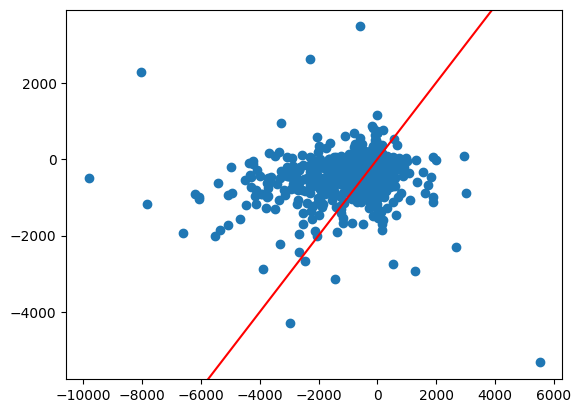

In [23]:
plt.figure(0)
plt.scatter(y_test, best_model.predict(X_test))
plt.axline((0,0), slope=1, c='r')

We can also compare the model to a naive predictor, like simply taking the average of overspent amount

In [24]:
average_train_overspent = np.mean(y_train)
y_pred_test = np.full(1767, average_train_overspent)
mean_absolute_error(y_test, y_pred_test)

562.8434170672238

In [25]:
r2_score(y_test, y_pred_test)

-0.031452263910849876

## Regression + Classification
Instead of just predicting the amount overspent, we can also split the model into both a regression and classification model. One will be responsible for predicting the absolute off-budget values, the other for predicting if this amount is overspent or underspent.

### Regression on Absolute off-budget values
We again start by dividing everything into train, validation and test sets.

In [26]:
X_train, X_valtest, y_train, y_valtest = sklearn.model_selection.train_test_split(final_data_regr_abs[:,:-1], final_data_regr_abs[:,-1], 
                                                                                  train_size=0.5, shuffle=False)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_valtest, y_valtest, train_size=0.5, shuffle=False)

Next, we do a parameter search and choose the best parameters based on performance on the validation set. The score metric here has a maximum value of 1.0 and no minimum value.

In [27]:
#no gridsearchcv because it doesn't allow for a validation set
best_score = -10000
for n_est, min_split, crit in product([25,50,100,200],
                                      [1,20,50], 
                                      ['squared_error','friedman_mse','poisson']): 
    #parameter search on 'n_estimators', 'min_samples_split' and 'criterion'
    model = RandomForestRegressor(n_estimators = n_est, min_samples_split = min_split, criterion = crit)
    model.fit(X_train, y_train)
    score = model.score(X_val, y_val)
    print("n_estimators: {},\tmin_samples_split: {},\tcriterion: {},\tscore: {}".format(n_est, min_split, crit, score))
    if score > best_score:
        best_score = score
        best_param = n_est, min_split, crit
        
print("Best parameters:\nn_estimators: {},\tmin_samples_split: {},\tcriterion: {},\tscore : {}".format(best_param[0], best_param[1], 
                                                                                                       best_param[2], best_score))

n_estimators: 25,	min_samples_split: 1,	criterion: squared_error,	score: -0.0006252146645513434
n_estimators: 25,	min_samples_split: 1,	criterion: friedman_mse,	score: -0.0005454996021214686
n_estimators: 25,	min_samples_split: 1,	criterion: poisson,	score: -0.0005856148355805058
n_estimators: 25,	min_samples_split: 20,	criterion: squared_error,	score: -0.00023290496048589127
n_estimators: 25,	min_samples_split: 20,	criterion: friedman_mse,	score: -0.00018188948322128695
n_estimators: 25,	min_samples_split: 20,	criterion: poisson,	score: -0.000196467552710633
n_estimators: 25,	min_samples_split: 50,	criterion: squared_error,	score: 0.00014175059967180825
n_estimators: 25,	min_samples_split: 50,	criterion: friedman_mse,	score: 6.237839325173855e-05
n_estimators: 25,	min_samples_split: 50,	criterion: poisson,	score: 8.554444331532185e-05
n_estimators: 50,	min_samples_split: 1,	criterion: squared_error,	score: -0.0006341783380214849
n_estimators: 50,	min_samples_split: 1,	criterion: fried

Now we take the model with the best performing parameters and test its performance on the test set

In [28]:
best_model = RandomForestRegressor(n_estimators = best_param[0], min_samples_split = best_param[1], criterion = best_param[2])
best_model.fit(X_train, y_train)
best_model.score(X_test, y_test)

0.32645330901113045

This score metric isn't the most intuitive, so let's compute mean absolute error on the test set as well.

In [29]:
mean_absolute_error(y_test, best_model.predict(X_test))

409.2393463438767

We can plot the predicted values against the true values in order to visualize how well the model performs

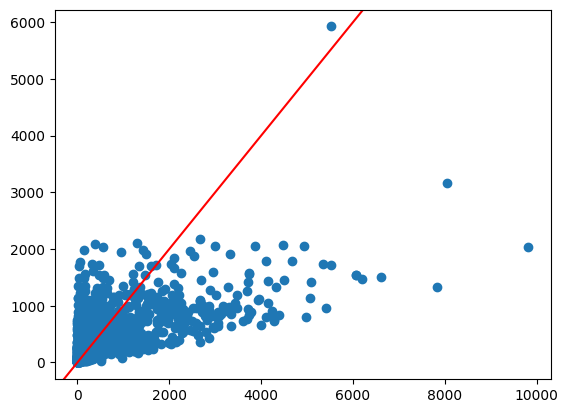

In [30]:
plt.figure(0)
plt.scatter(y_test, best_model.predict(X_test))
plt.axline((0,0), slope=1, c='r')

We once again compare to the naive predictor, which simply takes the average absolute overspent amount

In [31]:
average_train_overspent = np.mean(y_train)
y_pred_test = np.full(1767, average_train_overspent)
mean_absolute_error(y_test, y_pred_test)

556.3749265488983

In [32]:
r2_score(y_test, y_pred_test)

-0.011135315589121841

### Classification

In [33]:
X_train, X_valtest, y_train, y_valtest = sklearn.model_selection.train_test_split(final_data_class[:,:-1], final_data_class[:,-1], 
                                                                                  train_size=0.5, shuffle=False)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_valtest, y_valtest, train_size=0.5, shuffle=False)

Once again we do a parameter search to find the best hyperparameters, using the validation set. This time however, we use Random Forest Classifier instead of Regressor.

In [34]:
best_score = -10000
for n_est, min_split, crit in product([25,50,100,200], 
                                      [1,20,50], 
                                      ['gini', 'entropy', 'log_loss']): 
    #parameter search on 'n_estimators', 'min_samples_split' and 'criterion'
    model = RandomForestClassifier(n_estimators = n_est, min_samples_split = min_split)
    model.fit(X_train, y_train)
    score = f1_score(y_val, model.predict(X_val))
    print("n_estimators: {},\tmin_samples_split: {},\tcriterion: {},\tscore: {}".format(n_est, min_split, crit, score))
    if score > best_score:
        best_score = score
        best_param = n_est, min_split, crit
        
print("Best parameters:\nn_estimators: {},\tmin_samples_split: {},\tcriterion: {},\tscore : {}".format(best_param[0], best_param[1], 
                                                                                                       best_param[2], best_score))

n_estimators: 25,	min_samples_split: 1,	criterion: gini,	score: 0.2301675977653631
n_estimators: 25,	min_samples_split: 1,	criterion: entropy,	score: 0.2382022471910112
n_estimators: 25,	min_samples_split: 1,	criterion: log_loss,	score: 0.24288840262582062
n_estimators: 25,	min_samples_split: 20,	criterion: gini,	score: 0.07039999999999999
n_estimators: 25,	min_samples_split: 20,	criterion: entropy,	score: 0.09076682316118935
n_estimators: 25,	min_samples_split: 20,	criterion: log_loss,	score: 0.08062015503875969
n_estimators: 25,	min_samples_split: 50,	criterion: gini,	score: 0.01415929203539823
n_estimators: 25,	min_samples_split: 50,	criterion: entropy,	score: 0.007155635062611808
n_estimators: 25,	min_samples_split: 50,	criterion: log_loss,	score: 0.017391304347826087
n_estimators: 50,	min_samples_split: 1,	criterion: gini,	score: 0.24517593643586835
n_estimators: 50,	min_samples_split: 1,	criterion: entropy,	score: 0.2466367713004484
n_estimators: 50,	min_samples_split: 1,	criteri

In [35]:
best_model = RandomForestClassifier(n_estimators = best_param[0], min_samples_split = best_param[1], criterion = best_param[2])
best_model.fit(X_train, y_train)
best_model.score(X_test, y_test)

0.6734578381437465

In [36]:
F1 = f1_score(y_test, best_model.predict(X_test))
F1

0.21496598639455786

Let's also create a confusion matrix to get insight in which class the model struggles with the most

In [37]:
confusion_matrix(y_test, best_model.predict(X_test))

array([[1111,  280],
       [ 297,   79]], dtype=int64)

Structure of confusion matrix: (Negative = not overspent, positive = overspent)

| True Negative  | False Positive |
| --- | --- |
| False Negative | True Negative |

Clearly there is a bias in labeling instances as Not-Overspent, which may be due to the imbalanced dataset.

Once again we compare to a naive model, this time a model which simply picks a class uniformly at random

In [38]:
random_predictions = np.random.randint(2, size=y_test.shape)
acc_score = accuracy_score(y_test, random_predictions)
acc_score

0.49971703452178834

In [39]:
F1 = f1_score(y_test, random_predictions)
F1

0.3050314465408805

#### Balancing the datasets
The confusion matrix shows that there is a big class imbalance, which causes our accuracy score to be unreliable. Since the F1 score isn't great either, we will try to improve performance by balancing the datasets. We'll use undersampling to do this. Since undersampling will decrease the size of the dataset significantly, we will use a slightly larger training set than before. The training set will now be 70% of the complete dataset, and the validation and test sets both 15%.

In [40]:
X_train, X_valtest, y_train, y_valtest = sklearn.model_selection.train_test_split(final_data_class[:,:-1], final_data_class[:,-1], 
                                                                                  train_size=0.7, shuffle=False)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_valtest, y_valtest, train_size=0.5, shuffle=False)

In [41]:
#first check what the balance actually is, for each set we print no_overspending amount vs overspending amount
print(np.bincount(y_train.astype(int)))
print(np.bincount(y_val.astype(int)))
print(np.bincount(y_test.astype(int)))

[3534 1411]
[758 302]
[879 181]


In [42]:
#We undersample by randomly undersampling the dominant class. In this case this is the not-overspending class
rng = np.random.default_rng(seed=42) #create a random-number-generator with a seed for reproducibility

overspent_train_idx = y_train.nonzero()[0]     #find indices of the overspent class
notover_train_idx = np.nonzero(y_train==0)[0]  #find indices of the not-overspent class

#choose a random selection of not-overspent indices the same size as the overspent indices
rand_notover_train_idx = rng.choice(notover_train_idx, overspent_train_idx.size, replace=False)
final_train_idx = np.concatenate((overspent_train_idx, rand_notover_train_idx))

#do the same for the validation and test sets
overspent_val_idx = y_val.nonzero()[0]     
notover_val_idx = np.nonzero(y_val==0)[0]  
rand_notover_val_idx = rng.choice(notover_val_idx, overspent_val_idx.size, replace=False)
final_val_idx = np.concatenate((overspent_val_idx, rand_notover_val_idx))

overspent_test_idx = y_test.nonzero()[0]     
notover_test_idx = np.nonzero(y_test==0)[0]  
rand_notover_test_idx = rng.choice(notover_test_idx, overspent_test_idx.size, replace=False)
final_test_idx = np.concatenate((overspent_test_idx, rand_notover_test_idx))

We create out newly balanced datasets by indexing the sets we already had with the indices generated above.

In [43]:
X_train_bal, y_train_bal = X_train[final_train_idx,:], y_train[final_train_idx]
X_val_bal, y_val_bal = X_val[final_val_idx,:], y_val[final_val_idx]
X_test_bal, y_test_bal = X_test[final_test_idx,:], y_test[final_test_idx]

In [44]:
#let's see if it's balanced now:
print(np.bincount(y_train_bal.astype(int)))
print(np.bincount(y_val_bal.astype(int)))
print(np.bincount(y_test_bal.astype(int)))

[1411 1411]
[302 302]
[181 181]


With our newly balanced datasets, we can train a model much the same way as we did before:

In [45]:
best_score = -10000
for n_est, min_split, crit in product([25,50,100,200], 
                                      [1,20,50], 
                                      ['gini', 'entropy', 'log_loss']): 
    #parameter search on 'n_estimators', 'min_samples_split' and 'criterion'
    model = RandomForestClassifier(n_estimators = n_est, min_samples_split = min_split)
    model.fit(X_train_bal, y_train_bal)
    score = model.score(X_val_bal, y_val_bal) #since the dataset is now balanced we can use accuracy
    print("n_estimators: {},\tmin_samples_split: {},\tcriterion: {},\tscore: {}".format(n_est, min_split, crit, score))
    if score > best_score:
        best_score = score
        best_param = n_est, min_split, crit
        
print("Best parameters:\nn_estimators: {},\tmin_samples_split: {},\tcriterion: {},\tscore : {}".format(best_param[0], best_param[1], 
                                                                                                       best_param[2], best_score))

n_estimators: 25,	min_samples_split: 1,	criterion: gini,	score: 0.5231788079470199
n_estimators: 25,	min_samples_split: 1,	criterion: entropy,	score: 0.5099337748344371
n_estimators: 25,	min_samples_split: 1,	criterion: log_loss,	score: 0.5248344370860927
n_estimators: 25,	min_samples_split: 20,	criterion: gini,	score: 0.5033112582781457
n_estimators: 25,	min_samples_split: 20,	criterion: entropy,	score: 0.5082781456953642
n_estimators: 25,	min_samples_split: 20,	criterion: log_loss,	score: 0.5413907284768212
n_estimators: 25,	min_samples_split: 50,	criterion: gini,	score: 0.5298013245033113
n_estimators: 25,	min_samples_split: 50,	criterion: entropy,	score: 0.5298013245033113
n_estimators: 25,	min_samples_split: 50,	criterion: log_loss,	score: 0.49503311258278143
n_estimators: 50,	min_samples_split: 1,	criterion: gini,	score: 0.5115894039735099
n_estimators: 50,	min_samples_split: 1,	criterion: entropy,	score: 0.5364238410596026
n_estimators: 50,	min_samples_split: 1,	criterion: log_l

In [46]:
best_model = RandomForestClassifier(n_estimators = best_param[0], min_samples_split = best_param[1], criterion = best_param[2])
best_model.fit(X_train_bal, y_train_bal)
best_model.score(X_test_bal, y_test_bal)

0.5386740331491713

In [47]:
F1 = f1_score(y_test_bal, best_model.predict(X_test_bal))
F1

0.5322128851540616

In [48]:
confusion_matrix(y_test_bal, best_model.predict(X_test_bal))

array([[100,  81],
       [ 86,  95]], dtype=int64)

Structure of confusion matrix: (Negative = not overspent, positive = overspent)

| True Negative  | False Positive |
| --- | --- |
| False Negative | True Negative |

There is no longer a bias towards either class, but the model now seems to have no skill to recognize the classes. Perhaps undersampling caused there to be too little data to properly learn from.

Furthermore, the naive predictor on the balanced datasets:

In [49]:
random_predictions = np.random.randint(2, size=y_test_bal.shape)
acc_score = accuracy_score(y_test_bal, random_predictions)
acc_score

0.5082872928176796

In [50]:
F1 = f1_score(y_test_bal, random_predictions)
F1

0.5189189189189188

Clearly undersampling was not the solution, as the classification model now performs at the same level as the naive classifier. Perhaps by using oversampling techniques, which allow us to retain the data we have while still balancing the dataset, we can improve this performance. Or perhaps a Random Forest Classifier simply isn't suited for this particular task.